In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

### Creating the contextual bandit environment

In [2]:
# Creating simulator for the environment
class ContextBandit:
    def __init__(self, bandits=10):
        self.bandits = bandits
        self.arms = self.bandits
        self.init_distribution()
        self.updateState()

    def init_distribution(self):
        # Setting up different reward distribution over the actions for each state
        self.banditMatrix = np.random.rand(self.bandits, self.arms)


    def reward(self, prob, n=10):
        reward = 0
        # Iterates to generate a better sample
        for i in range(n):
            if np.random.random() < prob:
                reward += 1

        return reward

    # Gets the current state as the website the agent is at
    def getState(self):
        return self.state

    # Updates the current state
    def updateState(self):
        self.state = np.random.randint(self.bandits)

    def getReward(self, arm):
        return self.reward(self.banditMatrix[self.getState()][arm])
    
    # Simulates placing a recommendation and returns its associated reward
    def chooseArm(self, arm):
        reward = self.getReward(arm)
        self.updateState()
        return reward
    



In [3]:
# Set the numpy random seed
np.random.seed(42)
env = ContextBandit(bandits=10)
state = env.getState()
reward = env.chooseArm(1)
print(state)
print(reward)

6
2


In [4]:
# Set up the hyperparameters
# Number of bandits. For convenience we will have the number of arms equal to the number of bandits
bandits = 10

# Specify the batch size. Since we are looking at one state per play, our batch size is one
batchSize = 1

# The num+er of input neurons will be equal to the number of bandits as we want to recommand on of the websites
inNeuron = bandits
# The number of hidden neurons are arbitrarily choosen
hNeurons = 100
# The number of output neurons will be equal to the number of arms as we will recommand one of them
oNeurons = bandits 

# Specify the number of plays / epochs
epochs = 5000

# Specify the learning rate 
lr = 1e-2

In [5]:
# Creating a simple sequential feed-forward NN
model = torch.nn.Sequential(
    torch.nn.Linear(inNeuron, hNeurons),
    torch.nn.ReLU(), # Using RELU activation
    torch.nn.Linear(hNeurons, oNeurons),
    torch.nn.ReLU()
)

In [6]:
# Using Mean Square Error as our loss function
lossFun = torch.nn.MSELoss()

In [7]:
# Using ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
# We will also create a helper function to encode a vector where all but 1 element is set to zero. The nonzero element is set to 1 and indicates a purticular state in the state space
def oneHot(N, pos, val=1):
    oneHotVector = np.zeros(N)
    oneHotVector[pos] = val
    return oneHotVector

In [9]:
# We need another helper function to calculate the softmax . Since the banditMatrix has different reward probabilities for each action in a state, therefore the softmax will also generate different reward distributions over actions for each state
def softmax(av, tau):
    softm = np.exp(av /tau) / np.sum( np.exp(av / tau))
    return softm

In [10]:
# Creating the training loop function
def train(env, epochs=epochs, learning_rate=1e-2):
    # Creates a 1-order tensor (vector) of size bandits, where all values are zero except the one for current state. The current state will have a value of one
    currentState = torch.Tensor(oneHot(bandits, env.getState()))
    # Stores the rewards
    rewards = []

    for e in range(epochs):
        yPred = model(currentState)
        # Convert reward preditions to probability distribution with softmax
        avSoftmax = softmax(yPred.data.numpy(), tau=2.0)        
        avSoftmax = avSoftmax / avSoftmax.sum() # Normalize the distribution to ensure that the sum is equal to one
        actionChoice = np.random.choice(bandits, p=avSoftmax) # Next action is choosen based on the probability distribution
        # Takes action, to receive reward
        currentReward = env.chooseArm(actionChoice)
        # Copy the pyTorch data to numpy array
        oneHotReward = yPred.data.numpy().copy()
        # Updates oneHotReward array to use as labeled training data
        oneHotReward[actionChoice] = currentReward
        reward = torch.Tensor(oneHotReward)
        rewards.append(currentReward)
        loss = lossFun(yPred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Updates t he current environment state
        currentState = torch.Tensor(oneHot(bandits, env.getState()))
    return np.array(rewards)



In [11]:
rewards = train(env)

In [12]:
# Create the running average
runningRewards = [0]

for i, r in enumerate(rewards):
    meanReward = ( (i+1) * rewards[-1] + r) / (i+2)
    runningRewards.append(meanReward)


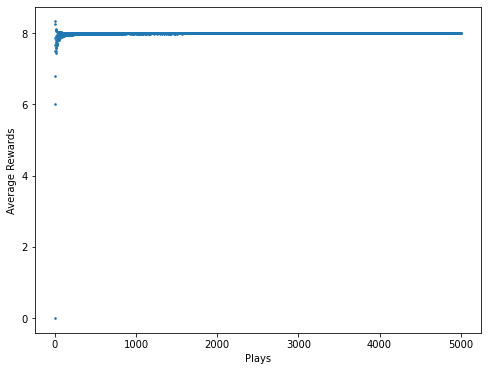

In [13]:
# Let us plot the running average rewards over the plays
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel('Plays')
ax.set_ylabel('Average Rewards')
ax.scatter(np.arange(epochs + 1), runningRewards, s=2.5)